##### Course: Data Science Workflow
##### Instructor: Prof. Felix Bießmann
##### Project: newsreader
##### Contributor: Saurav Kumar Saha

In [1]:
from bs4 import BeautifulSoup
from datetime import datetime
from IPython.display import IFrame

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import json
import os
import requests
import sys

import warnings
warnings.filterwarnings('ignore')

# from selenium import webdriver
# from selenium.webdriver.chrome.options import Options
# import time
# https://sites.google.com/a/chromium.org/chromedriver/downloads

### Newspaper Selected: bdnews24.com

In [2]:
IFrame("http://bangla.bdnews24.com/", width=1024, height=400)

### Parternship with Deutsche Welle

In [3]:
IFrame("https://www.dw.com/en/deutsche-welle-gains-new-partner-in-bangladesh/a-3707828", width=1024, height=400)

### Bangla Alphabets

In [4]:
IFrame("http://home.uchicago.edu/~cbs2/b_instruct_downloads/Bangla.alphabet.VidyaSagar.pdf", width=1024, height=400)

### Part: Scraping

In [5]:
# create directory for persisting news articles
datadir = r'D:\msc-ds\course-resource\data-science-workflow\Exam-2'
basedir = os.path.join(datadir, 'bangla.bdnews24.com')
os.makedirs(basedir, exist_ok=True)

In [6]:
# creating soup object from homepage
bdnews24_url = 'https://bangla.bdnews24.com'
homepage = BeautifulSoup(
    requests.get(bdnews24_url).text,
    'html.parser'
)

In [7]:
# extracting categories from homapage soup object
categories_ultag = homepage.find('ul', id='drop_down_body_menu')
categories = {litag.get_text(strip=True):litag.find('a', href=True)['href'] for litag in categories_ultag.find_all('li')}
categories = {category:(url if url.startswith('https://') else (bdnews24_url+url)) for category, url in categories.items()}

# removing 'classifieds' category as this page is only for advertisements (e.g. cars, apartments and houses, jobs)
categories.pop('', None)

# removing 'খবর'/'news' category as this url is same as the homepage, like 'Home' button
categories.pop('খবর', None)

categories

{'বাংলাদেশ': 'https://bangla.bdnews24.com/bangladesh/',
 'সমগ্র বাংলাদেশ': 'https://bangla.bdnews24.com/samagrabangladesh/',
 'খেলা': 'https://bangla.bdnews24.com/sport/',
 'ক্রিকেট': 'https://bangla.bdnews24.com/cricket/',
 'চট্টগ্রাম': 'https://bangla.bdnews24.com/ctg/',
 'রাজনীতি': 'https://bangla.bdnews24.com/politics/',
 'বিশ্ব': 'https://bangla.bdnews24.com/world/',
 'প্রবাস': 'https://bangla.bdnews24.com/probash/',
 'ক্যাম্পাস': 'https://bangla.bdnews24.com/campus/',
 'বাণিজ্য': 'https://bangla.bdnews24.com/business/',
 'পুঁজিবাজার': 'https://bangla.bdnews24.com/stocks/',
 'অর্থনীতি': 'https://bangla.bdnews24.com/economy/',
 'স্বাস্থ্য': 'https://bangla.bdnews24.com/health/',
 'পরিবেশ': 'https://bangla.bdnews24.com/environment/',
 'টেক': 'https://bangla.bdnews24.com/tech/',
 'গ্লিটজ': 'https://bangla.bdnews24.com/glitz/',
 'লাইফস্টাইল': 'https://bangla.bdnews24.com/lifestyle/',
 'কিডজ': 'https://bangla.bdnews24.com/kidz/',
 'বিজ্ঞান': 'https://bangla.bdnews24.com/science/',
 'সি

In [8]:
def category_parser(category_link, basedir, article_links_parser):
    
    # parse category from category_link
    category = category_name_parser(category_link)
    
    # create category directory
    categorydir = create_category_directory(basedir, category)
    
    # parse stopper numeric extracted from existing date-wise directories
    parse_stopper = extract_parse_stopper(basedir, category, 2)
    
    # create allnewspage soup object
    allnewslink = extract_allnewslink(category_link)
    allnewspage = BeautifulSoup(
        requests.get(allnewslink).text,
        'html.parser'
    )
    
    # collect all article links
    article_links = article_links_parser(allnewspage)

    # parse articles, collect in json formats and store
    new_extracted = 0
    total_extracted = 0
    for article_link in article_links:
        article = article_parser(article_link)
        article["article_category"] = category
        
        directory = datetime.strptime(article["article_published"], '%d %b %Y %I:%M %p BdST').strftime("%Y-%m-%d")
        datedir = os.path.join(categorydir, directory)
        
        if (datedir_to_numeric(directory) >= parse_stopper):
            os.makedirs(datedir, exist_ok=True)
            filepath = os.path.join(datedir, f'{article["article_id"]}' + '.json')
            if (not os.path.exists(filepath)):
                new_extracted += 1
            with open(filepath, 'w+', encoding='utf-8') as file:
                json.dump(article, file, ensure_ascii=False)
                total_extracted += 1
        else:
            break
    
    print('-----------------------------------')
    print(f'Category:       {category}')
    print(f'Total:          {total_extracted}')
    print(f'New:            {new_extracted}')
    print('-----------------------------------\n')


def category_name_parser(category_link):
    return category_link.split('/')[-2]


def create_category_directory(basedir, category):
    categorydir = os.path.join(basedir, category)
    os.makedirs(categorydir, exist_ok=True)
    return categorydir


def extract_parse_stopper(basedir, category, day_threshold=1):
    directories = [item.name for item in os.scandir(os.path.join(basedir, category)) if item.is_dir()]
    length = len(directories)
    if length == 0:
        return -1
    if (length > day_threshold):
        return datedir_to_numeric(directories[-day_threshold])
    else:
        return datedir_to_numeric(directories[-length])

    
def datedir_to_numeric(datedir):
    return int(datedir.replace('-', ''))


def extract_allnewslink(category_link):
    category_homepage = BeautifulSoup(
        requests.get(category_link).text,
        'html.parser'
    )
    
    allnewslink_div = category_homepage.find('div', id='latest_news2')
    # for cricket category
    if (not allnewslink_div):
        allnewslink_div = category_homepage.find('div', {'class': 'inpage-widget-1616583'})
        
    allnewslink = allnewslink_div.find('a', href=True)['href']
    
    missing_part = 'http'
    if (not allnewslink.startswith(missing_part)):
        allnewslink = missing_part + 's:' + allnewslink
    
    return allnewslink


# ALP01
def article_links_parser_01(allnewspage):
    content_ultag = allnewspage.find('ul', {'class': 'contentUL'})
    return [litag.find('a', {'class': 'articledetailedNew'}, href=True)['href'] for litag in content_ultag.find_all('li', {'class': 'article'})]


# ALP02
def article_links_parser_02(allnewspage):
    content_ultag = allnewspage.find('div', {'class': 'simplePagination'}).find('ul', {'class': 'pagination'})
    return [litag.find('a', {'class': 'article'}, href=True)['href'] for litag in content_ultag.find_all('li')]


def article_parser(article_link):
    article_id = article_link.split('/')[-1]
    
    article_page = BeautifulSoup(
        requests.get(article_link).text,
        'html.parser'
    )
    
    article_title = article_page.find('div', id='news-details-page').get_text().strip()
    
    article_by = article_page.find('div', {'class': 'article_byline'}).get_text()
    article_by = article_by.replace(u'\xa0', ' ').replace('\n', ' ')
    article_by = article_by.strip()
    if ('    ' in article_by):
        article_by = ', '.join([text.strip() for text in article_by.split('    ')])
    elif (',' in article_by):
        article_by = ', '.join([text.strip() for text in article_by.split(',')])
    
    article_published = article_updated = ''
    article_time_div = article_page.find('div', {'class': 'article_dateline'})
    article_time_spans = [span for span in article_time_div.find_all('span')]
    if (len(article_time_spans) == 4):
        article_published = article_time_spans[1].get_text().strip()
        article_updated = article_time_spans[3].get_text().strip()
    
    article_leadtext = ''
    article_leadtext_div = article_page.find('div', {'class': 'article_lead_text'})
    if (article_leadtext_div):
        article_leadtext = article_leadtext_div.get_text().strip()
    article_text_div = article_page.find('div', {'class': 'custombody'})
    article_text_paras = [para for para in article_text_div.find_all('p')]
    article_text = article_leadtext + extract_article_text(article_text_paras)
    article_text = '। '.join([line.strip() for line in article_text.split('।')]).strip()
    
    article = {
        "article_id": article_id,
        "article_title": article_title,
        "article_by": article_by,
        "article_published": article_published,
        "article_updated": article_updated,
        "article_leadtext": article_leadtext,
        "article_text": article_text
    }
    return article
    

def extract_article_text(article_paras):
    withImage = lambda p: p.find('img') != None
    withImageDesc = lambda p: (len(dict(p.attrs)) > 0) and ('id' in dict(p.attrs)) and (dict(p.attrs)['id'] == 'belowinlineimage')
    withAnchor = lambda p: p.find('a') != None
    withStrong = lambda p: p.find('strong') != None
    
    length = len(article_paras)
    text = ''
    for index in range(length):
        para = article_paras[index]    
        if (withImage(para) or withImageDesc(para)):
            continue
        if (withStrong(para)):
            if (index+1 < length):
                firstnext = article_paras[index+1]
                if (withStrong(firstnext) or withAnchor(firstnext)):
                    if (index+2 < length):
                        secondnext = article_paras[index+2]
                        if (withAnchor(secondnext)):
                            break;

        text += para.get_text().replace('\n', ' ')
    return text



In [36]:
categories_compatible_with_ALP01 = [
    'বাণিজ্য',
    'বাংলাদেশ',
    'স্বাস্থ্য',
    'পরিবেশ',
    'খেলা',
    'বিজ্ঞান',
    'প্রবাস',
    'রাজনীতি',
    'অর্থনীতি',
    'চট্টগ্রাম',
    'ক্রিকেট'
]
for compatible_category in categories_compatible_with_ALP01:
    category_parser(categories[compatible_category], basedir, article_links_parser_01)

-----------------------------------
Category:       business
Total:          17
New:            11
-----------------------------------

-----------------------------------
Category:       bangladesh
Total:          96
New:            56
-----------------------------------

-----------------------------------
Category:       health
Total:          4
New:            0
-----------------------------------

-----------------------------------
Category:       environment
Total:          3
New:            0
-----------------------------------

-----------------------------------
Category:       sport
Total:          26
New:            15
-----------------------------------

-----------------------------------
Category:       science
Total:          2
New:            0
-----------------------------------

-----------------------------------
Category:       probash
Total:          3
New:            1
-----------------------------------

-----------------------------------
Category:       politi

In [37]:
categories_compatible_with_ALP02 = [
    'বিশ্ব',
    'ক্যাম্পাস',
    'সমগ্র বাংলাদেশ',
    'পুঁজিবাজার'
]
for compatible_category in categories_compatible_with_ALP02:
    category_parser(categories[compatible_category], basedir, article_links_parser_02)

-----------------------------------
Category:       world
Total:          37
New:            18
-----------------------------------

-----------------------------------
Category:       campus
Total:          2
New:            0
-----------------------------------

-----------------------------------
Category:       samagrabangladesh
Total:          59
New:            36
-----------------------------------

-----------------------------------
Category:       stocks
Total:          9
New:            6
-----------------------------------



### Load collected articles as DataFrame

In [9]:
articles = []
for filepath in glob.glob(basedir + '/**/*.json', recursive=True):
    with open(filepath, encoding='utf-8') as file:
        articles.append(json.load(file))

df = pd.DataFrame(articles)
df.sample(5)

,article_id,article_title,article_by,article_published,article_updated,article_leadtext,article_text,article_category
1984,article1779932.bdnews,করোনাভাইরাস: বিশ্বজুড়ে একদিনে রেকর্ড রোগী শনাক্ত,"নিউজ ডেস্ক, বিডিনিউজ টোয়েন্টিফোর ডটকম",13 Jul 2020 10:01 AM BdST,13 Jul 2020 10:29 AM BdST,বিশ্বজুড়ে একদিনে রেকর্ড দুই লাখ ৩০ হাজার ৩৭০ জ...,বিশ্বজুড়ে একদিনে রেকর্ড দুই লাখ ৩০ হাজার ৩৭০ জ...,world
1666,article1768695.bdnews,পুঁজিবাজারে ‘কালো টাকা সাদা’ করার সুযোগ,নিজস্ব প্রতিবেদক বিডিনিউজ টোয়েন্টিফোর ডটকম,11 Jun 2020 05:26 PM BdST,11 Jun 2020 06:15 PM BdST,পুঁজিবাজারে অর্থের প্রবাহ বাড়াতে ‘কালো টাকা স...,পুঁজিবাজারে অর্থের প্রবাহ বাড়াতে ‘কালো টাকা স...,stocks
1929,article1778198.bdnews,করোনাভাইরাস: যুক্তরাষ্ট্রে শনাক্ত রোগী ৩০ লাখ ...,"নিউজ ডেস্ক, বিডিনিউজ টোয়েন্টিফোর ডটকম",08 Jul 2020 11:02 AM BdST,08 Jul 2020 11:11 AM BdST,বিশ্বজুড়ে ছড়িয়ে পড়া করোনাভাইরাস মহামারীর মধ্যে...,বিশ্বজুড়ে ছড়িয়ে পড়া করোনাভাইরাস মহামারীর মধ্যে...,world
349,article1776944.bdnews,এসআইবিএলে হিসাব খুললে ১০০ টাকা ক্যাশব্যাক,নিজস্ব প্রতিবেদক বিডিনিউজ টোয়েন্টিফোর ডটকম,04 Jul 2020 05:44 PM BdST,04 Jul 2020 05:44 PM BdST,বেসরকারি সোশ্যাল ইসলামী ব্যাংকে হিসাব ‍খুললে ১...,বেসরকারি সোশ্যাল ইসলামী ব্যাংকে হিসাব ‍খুললে ১...,business
489,article1776310.bdnews,ক্রিকেট ফেরাতে মাঠ প্রস্তুত রাখছে বিসিবি,"ক্রীড়া প্রতিবেদক, বিডিনিউজ টোয়েন্টিফোর ডটকম",02 Jul 2020 07:36 PM BdST,03 Jul 2020 02:58 PM BdST,করোনাভাইরাস পরিস্থিতির জন্য মার্চ থেকে বন্ধ দে...,করোনাভাইরাস পরিস্থিতির জন্য মার্চ থেকে বন্ধ দে...,cricket


In [10]:
article_counts = df\
.groupby(['article_category'])['article_id']\
.agg(['count'])\
.rename(columns={'count':'Count'})\
.sort_values(by='Count', ascending=False); article_counts

,Count
article_category,
bangladesh,277
world,271
samagrabangladesh,217
sport,173
stocks,166
politics,145
business,138
ctg,134
cricket,131


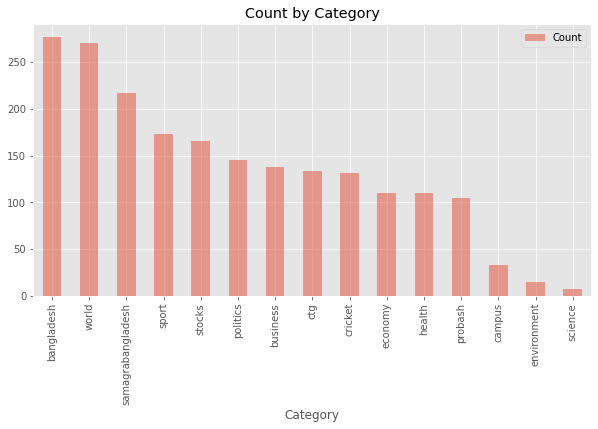

In [11]:
%matplotlib inline
plt.style.use('ggplot')
ax = article_counts.plot(
    kind='bar',
    figsize=(10,5),
    alpha=0.5,
    title='Count by Category'
)
ax.set_xlabel('Category');


### Some Pre-Processing

In [12]:
df['article_text'] = df['article_text'].str.replace('\xa0', ' ')
df['article_text'] = df['article_text'].str.replace('\u200d', ' ')
df['article_text'] = df['article_text'].str.replace('\u200c', '')

### Part: Article Category Prediction

In [13]:
df = df.sample(frac=1.0)
df.shape

(2032, 8)

In [14]:
article_categories = df.article_category.unique(); len(article_categories)

15

### Bangla Stop-Words Collection
##### https://github.com/stopwords-iso/stopwords-bn/blob/master/stopwords-bn.txt

In [15]:
stopwords_file = os.path.join(datadir, 'stopwords-bn.txt')
with open(stopwords_file, 'r', encoding='utf-8') as file:
    stop_words = [w.strip() for w in file.readlines()]

In [16]:
def train(articles, categories, stop_words, parameters):
    text_clf = Pipeline([
        (
            'vect',
            TfidfVectorizer(stop_words=stop_words)
        ),
        (
            'clf', 
            SGDClassifier(loss='log')
        )
    ])
    clf = GridSearchCV(
        text_clf,
        parameters,
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    clf.fit(articles, categories)
    return clf

In [17]:
parameters = {
    'vect__max_features': [int(number) for number in [1e5, 1e6, 1e7]],
    'vect__ngram_range': [(1, 1), (1, 3)],
    'clf__alpha': (np.logspace(-5, -1, 5)).tolist()
}

articles, categories = df.article_text, df.article_category
train_data, test_data, train_labels, test_labels = train_test_split(
    articles,
    categories,
    test_size=0.2,
    stratify=categories,
    random_state=2020
)

In [18]:
clf = train(
    articles=train_data,
    categories=train_labels,
    stop_words=stop_words,
    parameters=parameters
)

In [19]:
clf.best_params_

{'clf__alpha': 1e-05,
 'vect__max_features': 100000,
 'vect__ngram_range': (1, 3)}

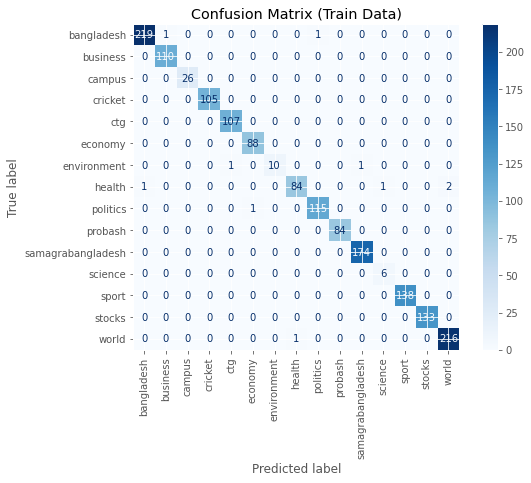

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Confusion Matrix (Train Data)')
plot_confusion_matrix(
    clf,
    train_data,
    train_labels,
    values_format='d',
    xticks_rotation='vertical',
    cmap=plt.cm.Blues,
    ax=ax
)
plt.show();

In [21]:
train_predictions = clf.predict(train_data)
print(classification_report(train_predictions, train_labels))

                   precision    recall  f1-score   support

       bangladesh       0.99      1.00      0.99       220
         business       1.00      0.99      1.00       111
           campus       1.00      1.00      1.00        26
          cricket       1.00      1.00      1.00       105
              ctg       1.00      0.99      1.00       108
          economy       1.00      0.99      0.99        89
      environment       0.83      1.00      0.91        10
           health       0.95      0.99      0.97        85
         politics       0.99      0.99      0.99       116
          probash       1.00      1.00      1.00        84
samagrabangladesh       1.00      0.99      1.00       175
          science       1.00      0.86      0.92         7
            sport       1.00      1.00      1.00       138
           stocks       1.00      1.00      1.00       133
            world       1.00      0.99      0.99       218

         accuracy                           0.99      

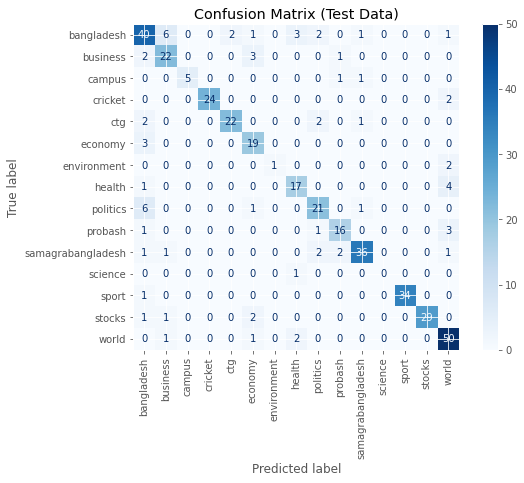

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Confusion Matrix (Test Data)')
plot_confusion_matrix(
    clf,
    test_data,
    test_labels,
    values_format='d',
    xticks_rotation='vertical',
    cmap=plt.cm.Blues,
    ax=ax
)
plt.show();

In [23]:
test_predictions = clf.predict(test_data)
print(classification_report(test_predictions, test_labels))

                   precision    recall  f1-score   support

       bangladesh       0.71      0.69      0.70        58
         business       0.79      0.71      0.75        31
           campus       0.71      1.00      0.83         5
          cricket       0.92      1.00      0.96        24
              ctg       0.81      0.92      0.86        24
          economy       0.86      0.70      0.78        27
      environment       0.33      1.00      0.50         1
           health       0.77      0.74      0.76        23
         politics       0.72      0.75      0.74        28
          probash       0.76      0.80      0.78        20
samagrabangladesh       0.84      0.90      0.87        40
          science       0.00      0.00      0.00         0
            sport       0.97      1.00      0.99        34
           stocks       0.88      1.00      0.94        29
            world       0.93      0.79      0.85        63

         accuracy                           0.83      

In [24]:
if 'article1781382.bdnews' not in list(df.article_id):
    print('Article Not Found ...')

Article Not Found ...


In [25]:
text = '''
আলফ্রেদো দে স্তেফানো স্টেডিয়ামে বৃহস্পতিবার ভিয়ারিয়ালকে ২-১ গোলে হারিয়ে উৎসবে মেতে ওঠে জিদনের দল।

প্রতিযোগিতার ইতিহাসে রেকর্ড চ্যাম্পিয়ন রিয়ালের এটি ৩৪তম শিরোপা। এর আগে ২০১৬-১৭ মৌসুমে শেষবার লিগের মুকুট পরেছিল তারা।

আক্রমণাত্মক শুরু করা রিয়াল প্রথম সাত মিনিটে ভালো দুটি আক্রমণ করে; তবে সাফল্য মেলেনি। তৃতীয় মিনিটে দানি কারভাহালের দুর্বল লবের চার মিনিট পর লুকা মদ্রিচও দুর্বল শট নেন। খানিক পর লক্ষ্যভ্রষ্ট শটে হতাশ করেন করিম বেনজেমাও।

২৯তম মিনিটে গোলের দেখা পায় রিয়াল। মাঝমাঝে প্রতিপক্ষের পাস ধরে কাসিমিরো বাড়ান সামনে। মদ্রিচ বল ধরে একটু এগিয়ে ডান দিকে বাড়ান বেনজেমাকে। ডি-বক্সে জায়গা বানিয়ে কোনাকুনি শটে গোলরক্ষকের দুই পায়ের ফাঁক দিয়ে ঠিকানা খুঁজে নেন আসরের দ্বিতীয় সর্বোচ্চ গোলদাতা।

২০০৯ সালে লিওঁ থেকে বের্নাবেউয়ে যোগ দেওয়া বেনজেমা এই প্রথম লা লিগায় টানা দুই মৌসুমে ২০ বা তার বেশি গোল করলেন। গত মৌসুমে করেছিলেন ২১টি।

দ্বিতীয়ার্ধের অষ্টম মিনিটে ব্যবধান দ্বিগুণ করার সুযোগ তৈরি করেছিলেন কারভাহাল। তবে একজনকে কাটিয়ে তার নেওয়া শট রুখে দেন গোলরক্ষক সের্হিও আসেনহো।

৬৬তম মিনিটে বাঁ দিক দিয়ে ডি-বক্সে ঢুকে পড়া চাভি কিনতিয়াকে রুখতে ছুটে যান কোর্তোয়া। বল নিয়ন্ত্রণে নিলেও প্রতিপক্ষের ডিফেন্ডারের হাঁটুতে মাথায় আঘাত পান বেলজিয়ান গোলরক্ষক। তবে, মাঠেই প্রাথমিক চিকিৎসা নিয়ে খেলা চালিয়ে যান তিনি।

৭৭তম মিনিটে ঘটনাহুল পেনাল্টি গোলে শিরোপা অনেকটাই নিশ্চিত করে ফেলেন বেনজেমা। রামোস ডি-বক্সে ফাউলের শিকার হলে পেনাল্টিটি পায় রিয়াল।

স্পট কিক নিতে এসে আলতো টোকায় বল একটু সামনে বাড়ান অধিনায়ক রামোস, ছুটে এসে জোরালো শটে লক্ষ্যভেদ করেন বেনজেমা। প্রতিবাদ জানায় সফরকারীরা। অবশ্য রামোসের টোকার আগেই বেনজেমা ডি-বক্সে ঢুকে পড়ায় আবার পেনাল্টি শট নিতে হয় রিয়ালকে। এবার আর কোনো বাড়তি ঘটনা নয়, নিচু শটে আসরে নিজের ২১তম গোলটি করেন ফরাসি ফরোয়ার্ড।   

চার মিনিট পর তারা পেতে পারতো আরেক গোল। কিন্তু টনি ক্রুসের দূরপাল্লার জোরালো শট ক্রসবারে বাধা পায়।

৮৩তম মিনিটে ডান দিক থেকে সতীর্থের ক্রসে হেডে ইবোরা ঠিকানা খুঁজে পেলে নাটকীয়তার সম্ভাবনা জাগে। ব্যবধান কমিয়ে উজ্জীবিত হয়ে ওঠে ভিয়ারিয়াল। ৮৮তম মিনিটে সমতাও টানতে পারতো তারা; তবে মুহূর্তের ব্যবধানে দুটি সুযোগ হারায় দলটি।

যোগ করা সময়ে জালে বল পাঠিয়েছিলেন মার্কো আসেনসিও। তবে তাকে পাস দেওয়া বেনজেমার হাতে বল লাগায় ভিএআরের সাহায্যে হ্যান্ডবলের বাঁশি বাজান রেফারি। 
'''
prediction = clf.predict(pd.Series(text.replace('\n', ' '))); prediction[0]

'sport'

### References

##### 1. https://en.wikipedia.org/wiki/International_Phonetic_Alphabet
##### 2. https://en.wikipedia.org/wiki/Bengali_(Unicode_block)
##### 3. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
##### 4. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
##### 5. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix
##### 6. https://scikit-learn.org/stable/modules/sgd.html